**Uploading the zip file from local storage**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Image_set.zip to Image_set.zip


**Extracting the zip file**

In [ ]:
from zipfile import ZipFile
file_name = '/content/Image_set.zip'


with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Dataset Extracted!')

Dataset Extracted!


In [ ]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import torch.nn.functional as F
import math
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader
import time
from sklearn.metrics import mean_absolute_error
cuda = torch.cuda.is_available()

print("Libraries imported!")

Libraries imported!


**Setting dataset paths**



In [ ]:
# Train Dataset
train_images_path = glob('/content/training_set/images/*')
train_groundtruth_path = glob('/content/training_set/groundtruths/*')
train_masks_path = glob('/content/training_set/masks/*')

# Test Data set
test_images_path = glob('/content/testing_set/images/*')
test_groundtruth_path = glob('/content/testing_set/groundtruths/*')
test_masks_path = glob('/content/testing_set/masks/*')

# Resizing to 256x256
width = 256
height = 256
dim = (width, height)

**Loading the dataset**

In [ ]:
class Segment(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        # Images
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        image = image/255.0
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        # Masks
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
        mask = mask/255.0
        mask = np.transpose(mask, (2, 0, 1))
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

**Setting up Hyperparameters**

In [ ]:
# Split Ratio for train test
val_percent = 0.3

# Loader workers
num_workers = 4 if cuda else 0 

# Batch size
batch_size = 10

# Number training iterations
num_epochs = 100

# Learning rate
learn_rate = 1e-2

# Checkpoint path
checkpoint_path = "/content/files/checkpoint.pth"


**Creating the datasets**

In [ ]:
train_dataset = Segment(train_images_path, train_masks_path)
test_set = Segment(test_images_path, test_masks_path)

**Creating train test split**

In [ ]:
n_val = int(len(train_dataset) * val_percent)
n_train = len(train_dataset) - n_val
train_set, val_set = random_split(train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

data_str = f"Training size: {len(train_set)}\tValidation size: {len(val_set)}\tTesting size: {len(test_set)}\n"
print(data_str)

Training size: 1048	Validation size: 448	Testing size: 100



**Creating dataloader**

In [ ]:
# Training data
train_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
train_loader = DataLoader(train_set, **train_loader_args)

# Validation data
val_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_set, **val_loader_args)

# Testing data
test_loader_args = dict(shuffle=False, num_workers=num_workers) if cuda\
                    else dict(shuffle=False,drop_last=True)
test_loader = DataLoader(test_set, **test_loader_args)


**Dice Loss** 

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice


**Using U-Net as my model**

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


In [ ]:
device = torch.device("cuda" if cuda else "cpu")
model = build_unet()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceLoss()
model = model.to(device)

**Utility Functions**

In [ ]:
# Calculate the time taken 
def train_time(start_time, end_time):
    tot_time = end_time - start_time
    mins = int(tot_time / 60)
    secs = int(tot_time - (mins * 60))
    return mins, secs

**Training and Validation Functions**

In [ ]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    print("Training......")
    model.train()
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    print("Evaluating......")
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

**Training and Evaluation of the model**

In [ ]:
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

In [ ]:
best_valid_loss = float("inf")

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, val_loader, loss_fn, device)
    if valid_loss < best_valid_loss:
        data_str = f"Val loss improvement: {best_valid_loss:2.4f} --> {valid_loss:2.4f}\nSaving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    mins, secs = train_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Time: {mins}m {secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\tVal Loss: {valid_loss:.3f}\n'
    print(data_str)

Training......
Evaluating......
Val loss improvement: inf --> 0.2878
Saving checkpoint: /content/files/checkpoint.pth
Epoch: 01 | Time: 1m 20s
	Train Loss: 0.430
	Val Loss: 0.288

Training......
Evaluating......
Val loss improvement: 0.2878 --> 0.2431
Saving checkpoint: /content/files/checkpoint.pth
Epoch: 02 | Time: 1m 13s
	Train Loss: 0.224
	Val Loss: 0.243

Training......
Evaluating......
Val loss improvement: 0.2431 --> 0.2004
Saving checkpoint: /content/files/checkpoint.pth
Epoch: 03 | Time: 1m 14s
	Train Loss: 0.203
	Val Loss: 0.200

Training......
Evaluating......
Val loss improvement: 0.2004 --> 0.1698
Saving checkpoint: /content/files/checkpoint.pth
Epoch: 04 | Time: 1m 14s
	Train Loss: 0.178
	Val Loss: 0.170

Training......
Evaluating......
Val loss improvement: 0.1698 --> 0.1609
Saving checkpoint: /content/files/checkpoint.pth
Epoch: 05 | Time: 1m 14s
	Train Loss: 0.159
	Val Loss: 0.161

Training......
Evaluating......
Epoch: 06 | Time: 1m 14s
	Train Loss: 0.144
	Val Loss: 0

KeyboardInterrupt: ignored

**Testing function**

In [ ]:
def predict(model, loader, loss_fn, device):
    epoch_loss = 0
    y_preds = []
    print("Testing Model......")
    with torch.no_grad():
        model.eval()
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            y_preds.append(y_pred)
        epoch_loss = epoch_loss/len(loader)
    return epoch_loss, y_preds


In [ ]:
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
test_loss, pred_masks = predict(model, test_loader, loss_fn, device)

Testing Model......


**Visualizing results**


<ipython-input-47-d2fe45ae1e2a>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,20))


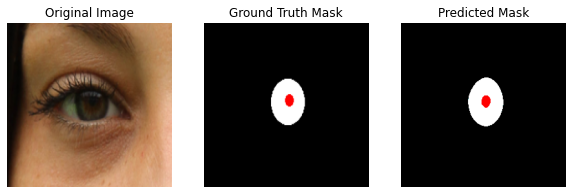

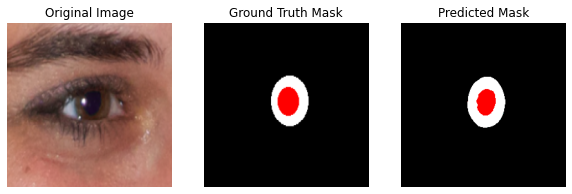

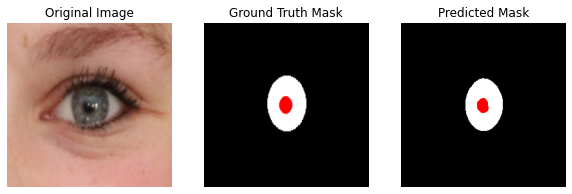

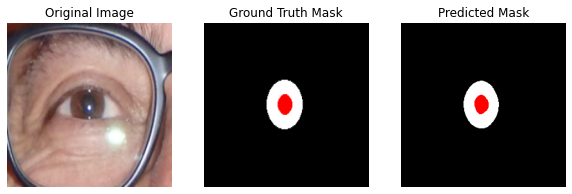

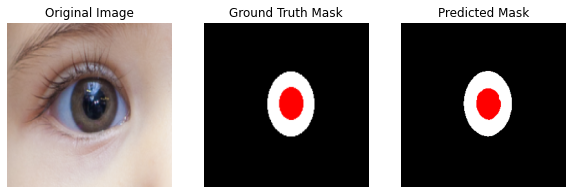

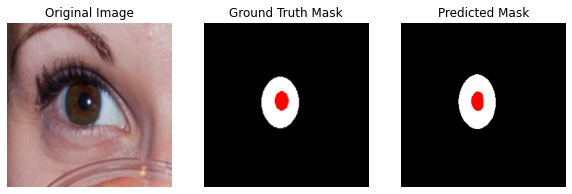

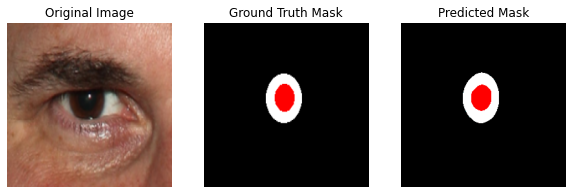

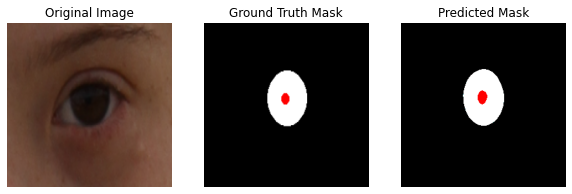

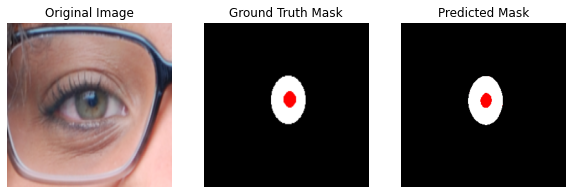

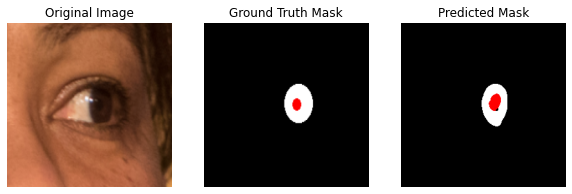

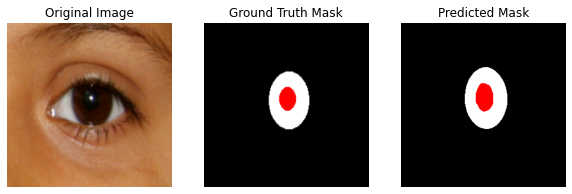

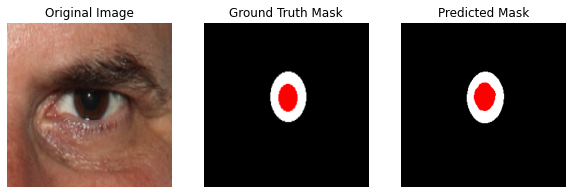

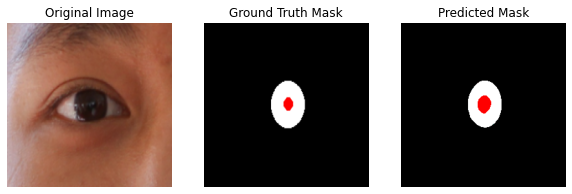

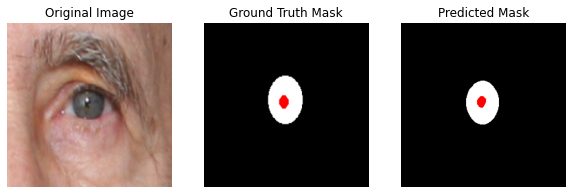

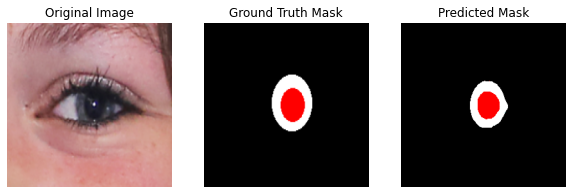

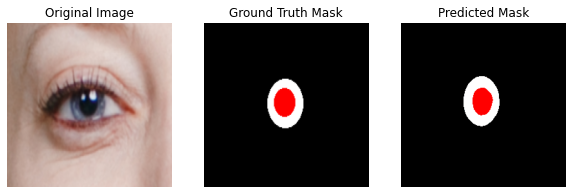

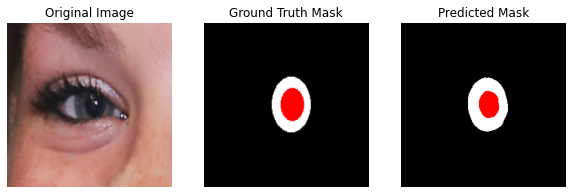

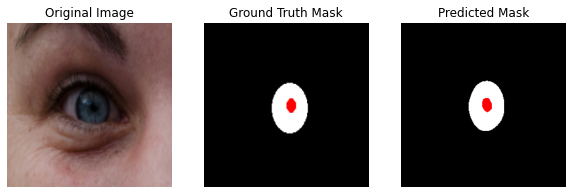

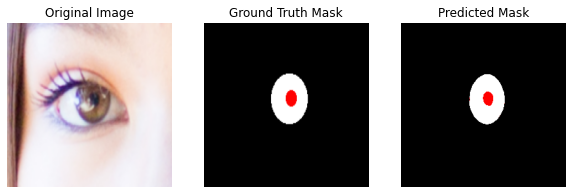

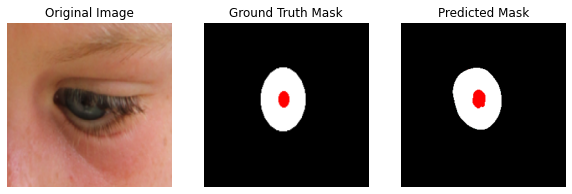

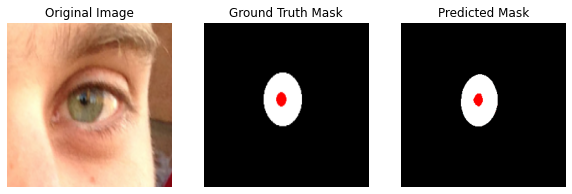

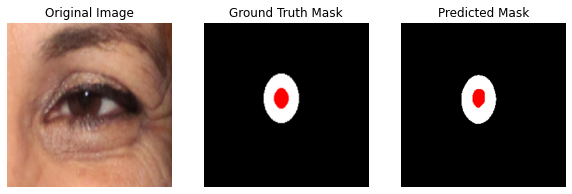

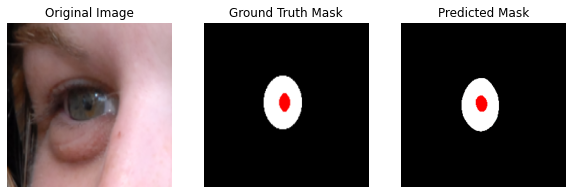

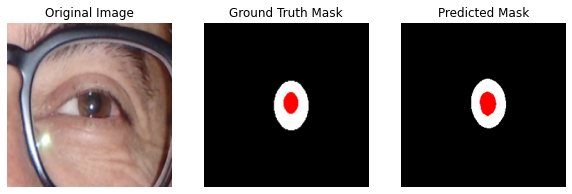

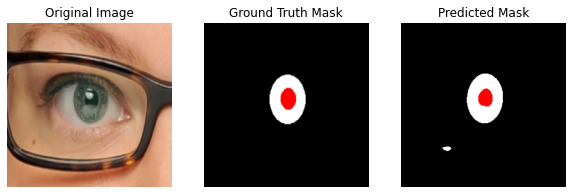

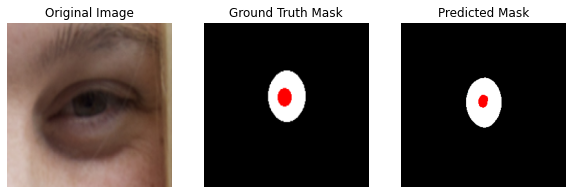

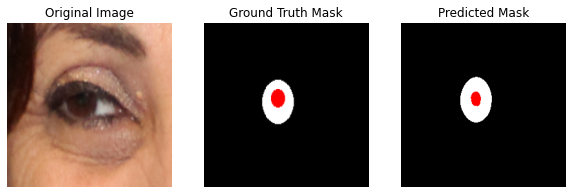

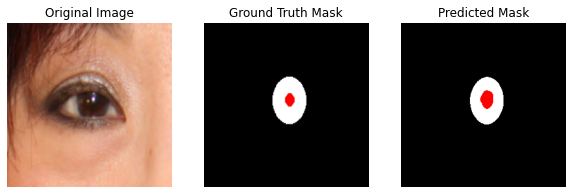

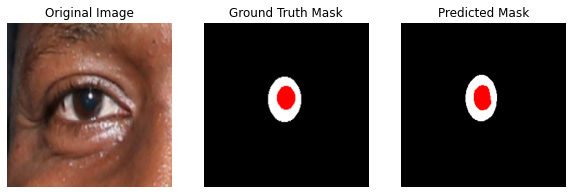

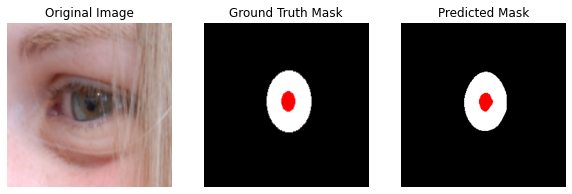

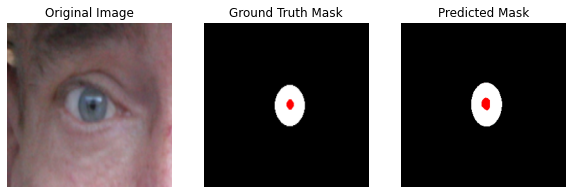

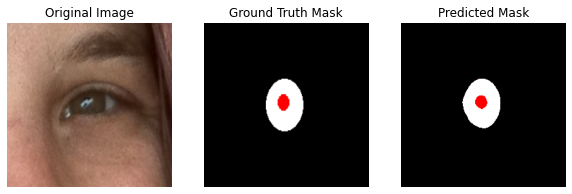

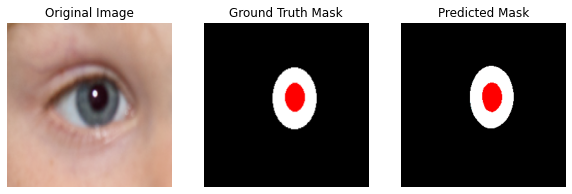

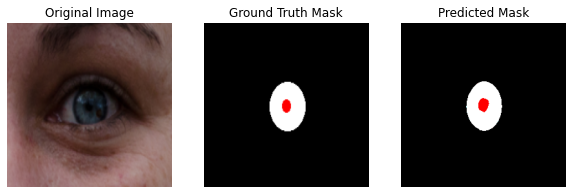

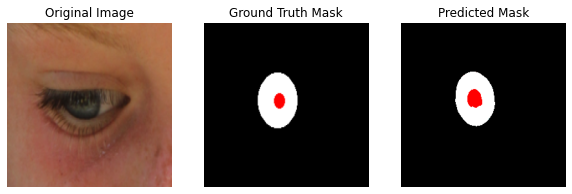

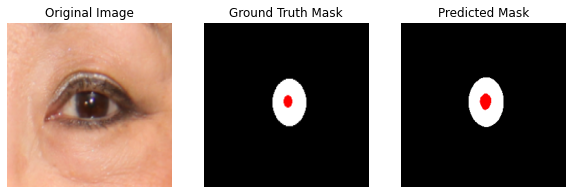

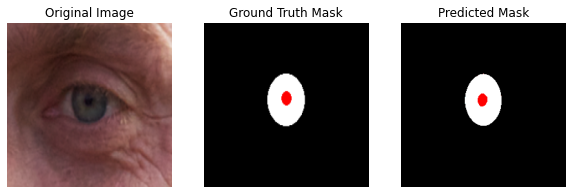

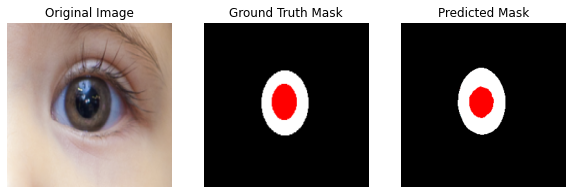

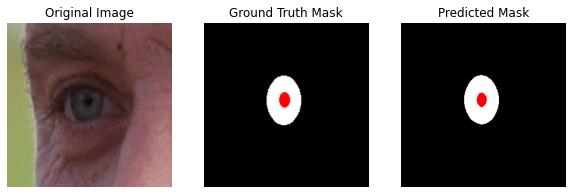

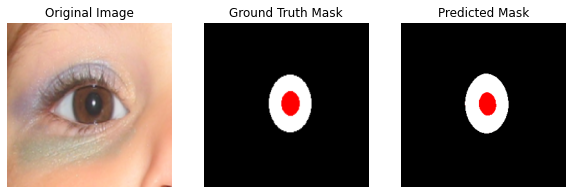

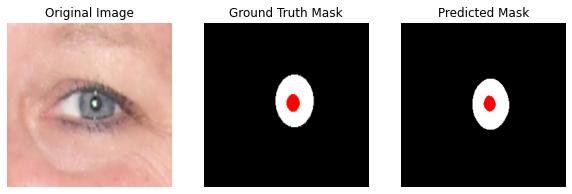

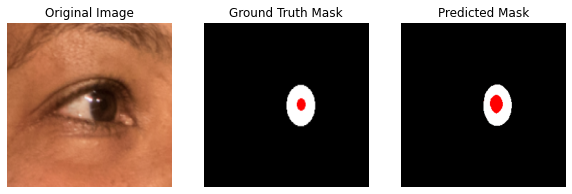

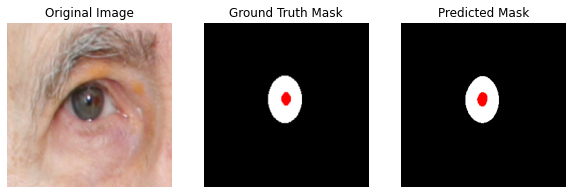

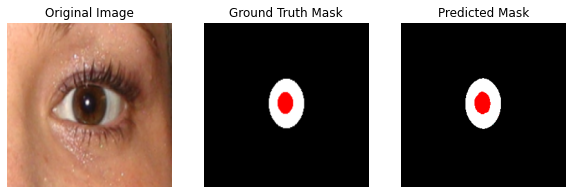

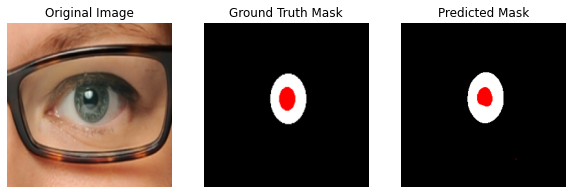

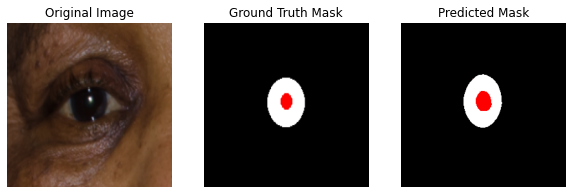

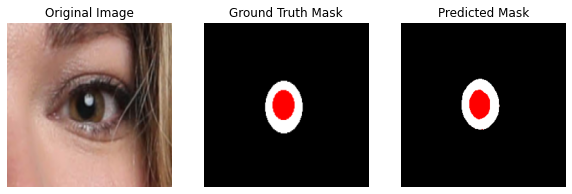

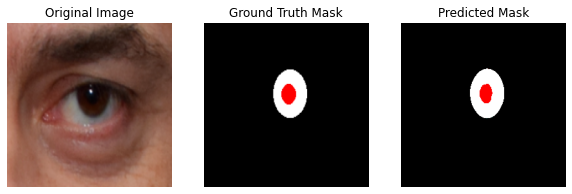

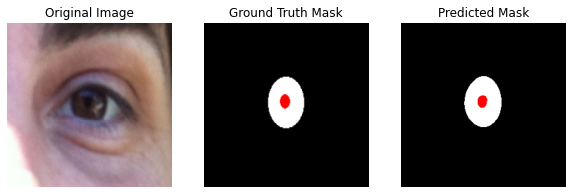

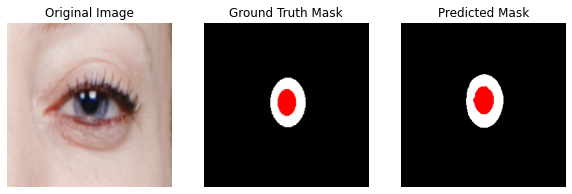

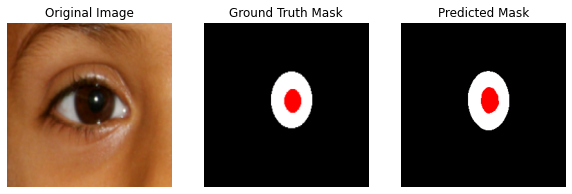

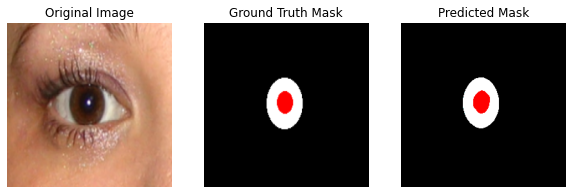

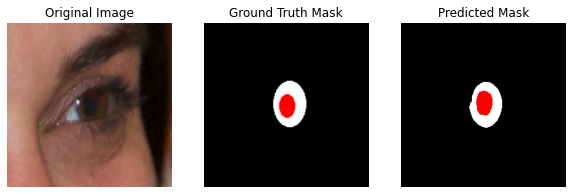

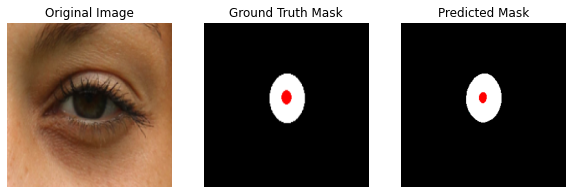

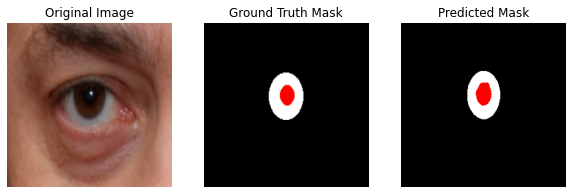

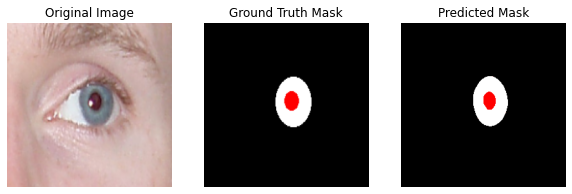

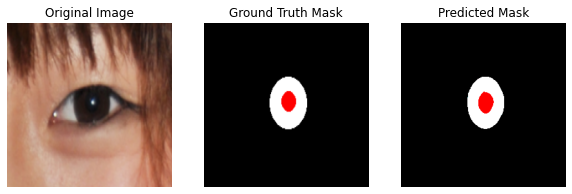

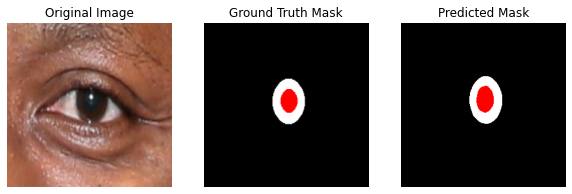

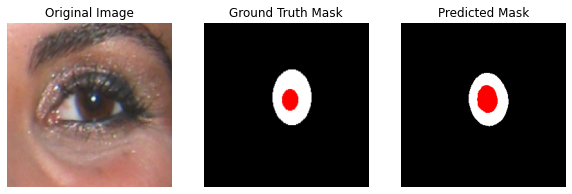

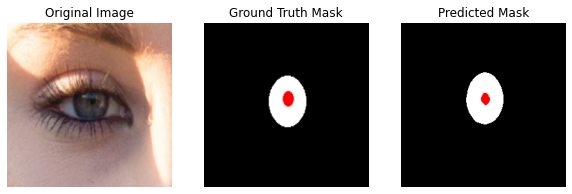

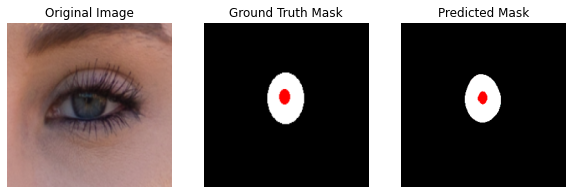

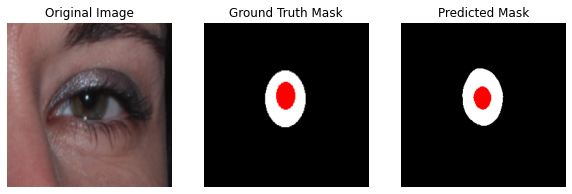

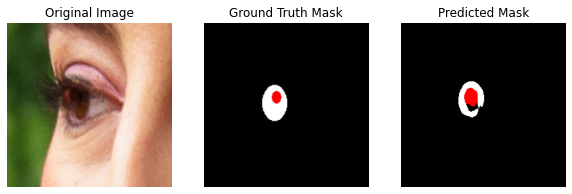

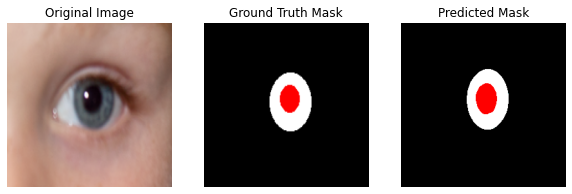

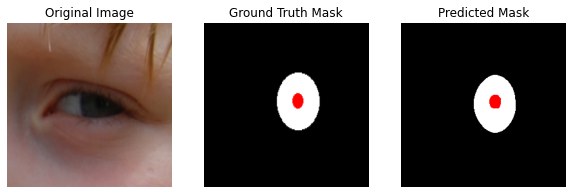

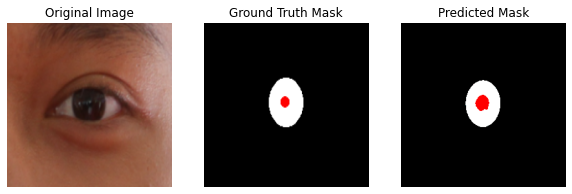

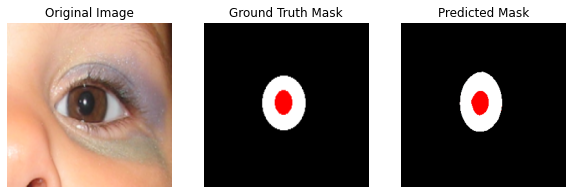

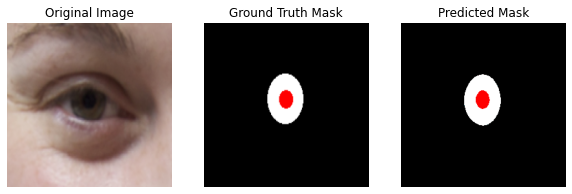

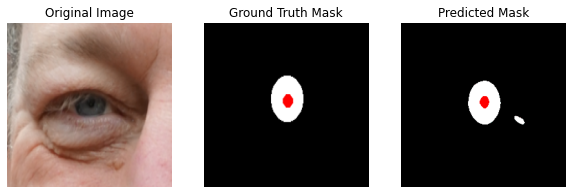

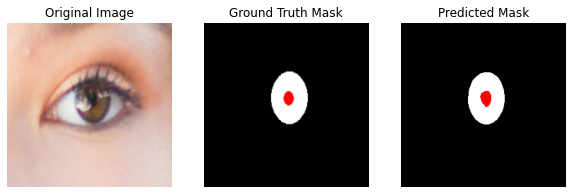

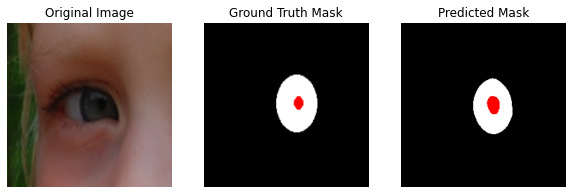

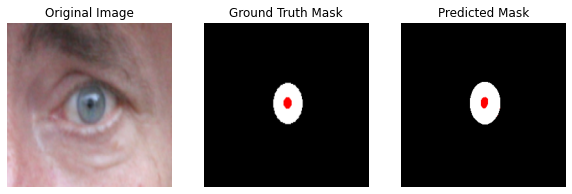

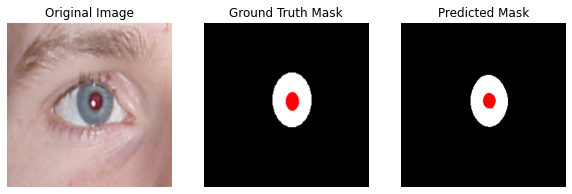

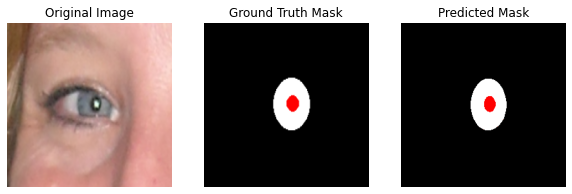

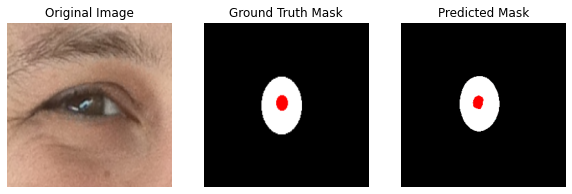

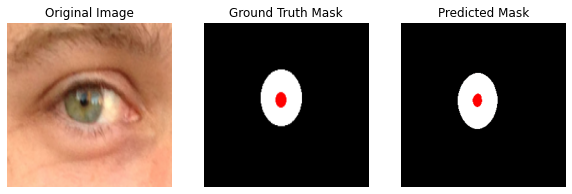

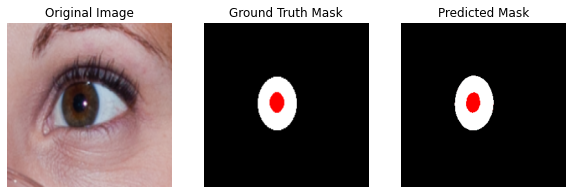

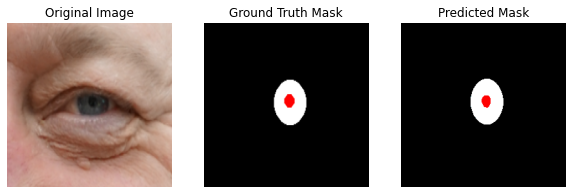

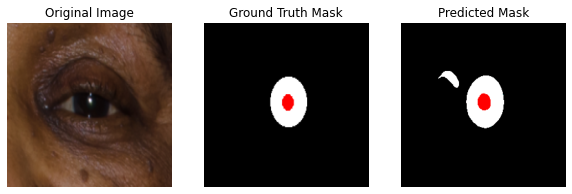

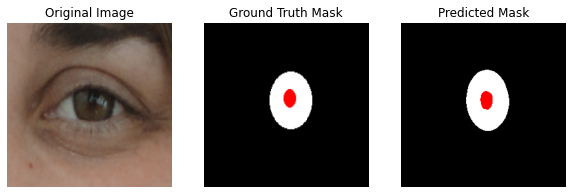

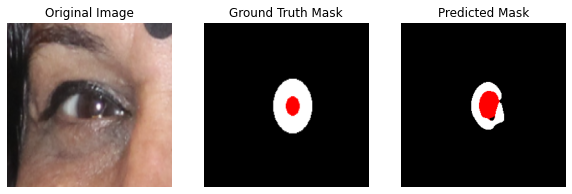

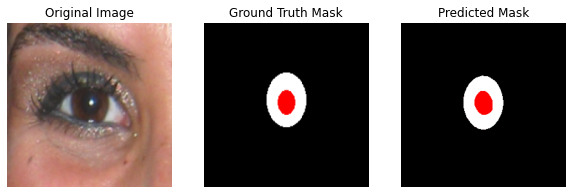

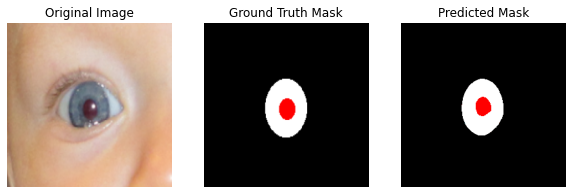

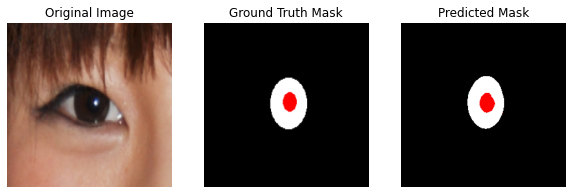

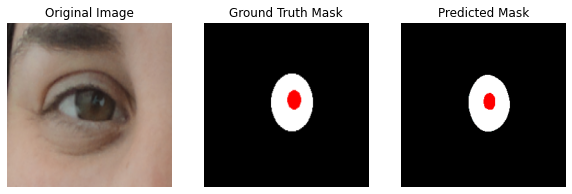

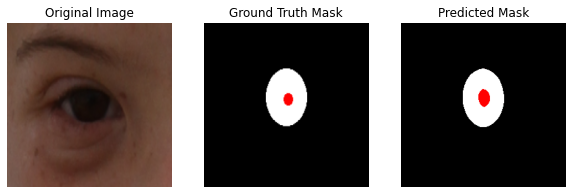

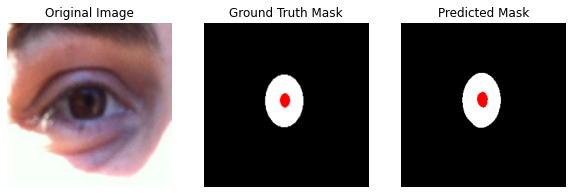

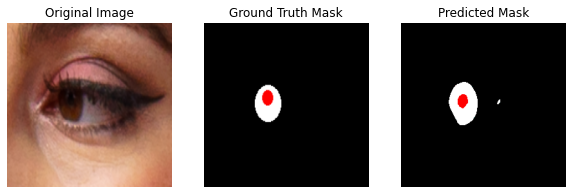

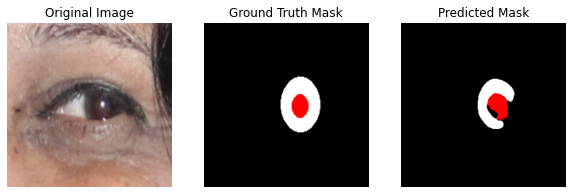

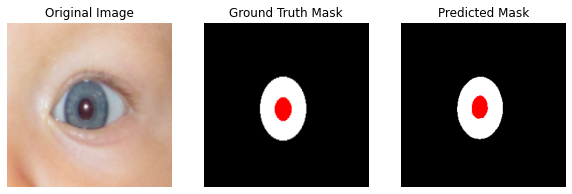

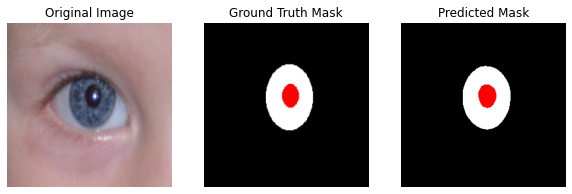

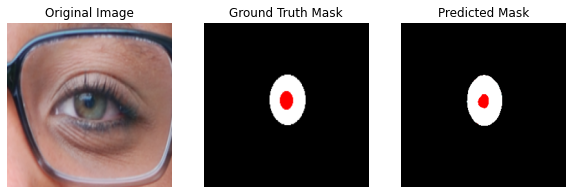

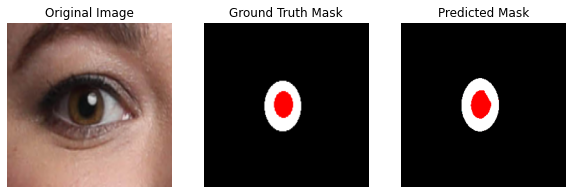

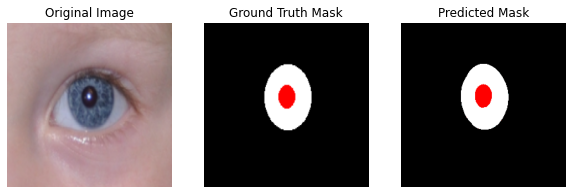

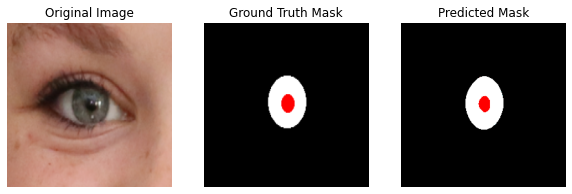

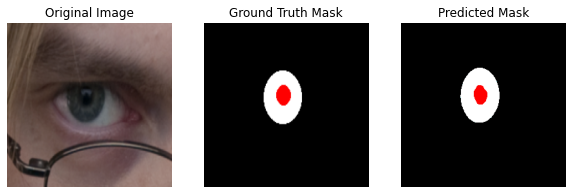

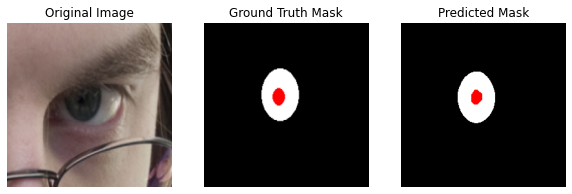

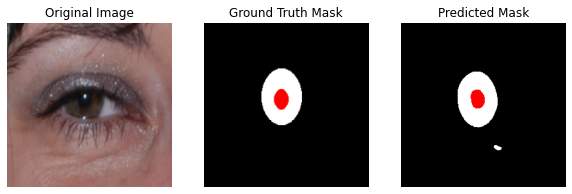

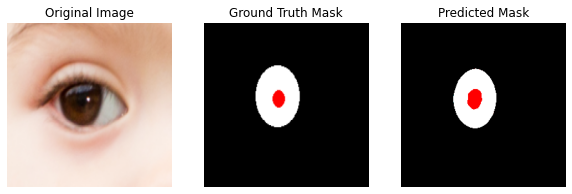

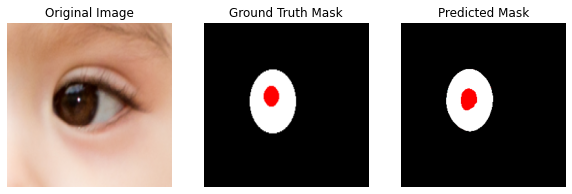

In [ ]:
num_test_items = len(test_set)

for i in range(num_test_items):
  # Actual Image
  original_test_image = test_set[i][0].cpu().numpy()
  original_test_image = np.squeeze(original_test_image) 
  original_test_image = np.transpose(original_test_image, (1, 2, 0))

  # Ground truth mask
  ground_truth_mask = test_set[i][1].cpu().numpy()
  ground_truth_mask = np.squeeze(ground_truth_mask) 
  ground_truth_mask = np.transpose(ground_truth_mask, (1, 2, 0))

  # Predicted mask
  predicted_mask = pred_masks[i].cpu().numpy()
  predicted_mask = np.squeeze(predicted_mask) 
  predicted_mask = np.transpose(predicted_mask, (1, 2, 0))   
  resized_predicted_mask = cv2.resize(predicted_mask, (224,160))
  scaled_predicted_mask = resized_predicted_mask * 255
  file_path = "/content/pred_masks/pred_im" + str(i) + ".png"
  cv2.imwrite(file_path, scaled_predicted_mask)

  # Plotting all three
  plt.figure(figsize=(10,20))
  plt.subplot(1,3,1)
  plt.imshow(original_test_image)
  plt.axis("off")
  plt.title("Original Image")
  plt.subplot(1,3,2)
  plt.imshow(ground_truth_mask, cmap='gray')
  plt.axis("off")
  plt.title("Ground Truth Mask")
  plt.subplot(1,3,3)
  plt.imshow(predicted_mask, cmap='gray')
  plt.axis("off")
  plt.title("Predicted Mask")


**Estimate the Iris Diameter**

In [ ]:
# Estimating Iris diameter of predicted images

pred_masks_path = glob('/content/pred_masks/*')
pred_iris_dia = []
for pred_mask in pred_masks_path:

  imgG = cv2.imread(pred_mask, 0)
  imgO = cv2.imread(file_path)
  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=30, param2=15, minRadius=0, maxRadius=50)

  # Determine if any circles were found
  if circles is None:
      print("No circles found")
      pred_iris_dia.append(80)
  else:
      circles = np.round(circles[0, :]).astype("int")
      
      # drawing the circles
      for (x, y, r) in circles:
          cv2.circle(imgO, (x, y), r, (255, 2550, 0), 1)
          pred_iris_dia.append(r*2)

In [ ]:
# Estimating the Iris diameter of ground-truth images


gt_masks_path = glob('/content/testing_set/masks/*')
gt_iris_dia = []
for gt_mask in gt_masks_path:
  imgG = cv2.imread(gt_mask, 0)
  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=30, param2=15, minRadius=0, maxRadius=50)

  # Determine if any circles were found
  if circles is None:
      print("No circles found")
      pass
  else:
      circles = np.round(circles[0, :]).astype("int")
      # draw the circles
      for (x, y, r) in circles:
          cv2.circle(imgG, (x, y), r, (255, 2550, 0), 1)
          gt_iris_dia.append(r*2)

**Estimate the Pupil Diameter**

In [ ]:
# Estimating the pupil diameter of predicted images

pred_masks_path = glob('/content/pred_masks/*')
pred_pupil_dia = []
for pred_mask in pred_masks_path:
  imgG = cv2.imread(pred_mask, 0)
  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=20, param2=22, minRadius=0, maxRadius=25)

  # Determine if any circles were found
  if circles is None:
      pred_pupil_dia.append(10*2)
  else:
      circles = np.round(circles[0, :]).astype("int")

      # draw the circles
      for (x, y, r) in circles:
          cv2.circle(imgG, (x, y), r, (255, 2550, 0), 1)
          pred_pupil_dia.append(r*2)
          cv2.imwrite("houghOutput.png", imgG)

In [ ]:
# Estimating the pupil diameter of ground-truth images


gt_masks_path = glob('/content/testing_set/masks/*')
gt_pupil_dia = []
for gt_mask in gt_masks_path:
  imgG = cv2.imread(gt_mask, 0)
  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=20, param2=22, minRadius=0, maxRadius=25)

  # Determine if any circles were found
  if circles is None:
      gt_pupil_dia.append(10*2)
  else:
      circles = np.round(circles[0, :]).astype("int")

      # draw the circles
      for (x, y, r) in circles:
          cv2.circle(imgG, (x, y), r, (255, 2550, 0), 1)
          gt_pupil_dia.append(r*2)

In [ ]:
# Predicted diameters
predicted_iris=np.array(pred_iris_dia)
predicted_pupil=np.array(pred_pupil_dia)


# Groundtruth diameters
ground_iris=np.array(gt_iris_dia)
ground_pupil=np.array(gt_pupil_dia)

**Iris Diameter MAE**

In [ ]:
m = np.mean((abs(predicted_iris-ground_iris)/ground_iris) * 100)
ans = f'Mean Absolute % Iris diameter error is: {m:.3f} %\n'
print(ans)

Mean Absolute % Iris diameter error is: 23.747 %



**Pupil diameter MAE**

In [ ]:
m = np.mean((abs(predicted_pupil-ground_pupil)/ground_pupil) * 100)
ans = f'Mean Absolute % Pupil diameter error is: {m:.3f} %\n'
print(ans)

Mean Absolute % Pupil diameter error is: 59.716 %



**Evaluating IoU**

In [ ]:
print("The Dice score is: "+str(1-test_loss))

The Dice score is: 0.9290970200300217
